In [1]:
import torch, pdb
from torch.utils.data import DataLoader
from torch import nn
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

In [3]:
def show(tensor, ch=1, size=(28,28), n=16):
    # tensor shape (128, 784)
    data = tensor.detach().cpu().view(-1, ch, *size)
    grid = make_grid(data[:n], nrow=4).permute(1,2,0)
    plt.imshow(grid)
    plt.show()

In [4]:
# Setup main params and hyperparams
epochs = 500
current_step = 0
show_step_interval = 300
mean_g_loss = 0 # mean of generator loss
mean_d_loss = 0 # mean of discriminator loss

d_z = 64
learning_rate = 0.00001 # Usually used for Adam optimizer
loss_func = nn.BCEWithLogitsLoss() # Binary Cross Entropy Loss applying sigmoid function to the nn output

batch_size = 128
device = 'cuda' if torch.cuda.is_available() else 'cpu'

dataloader = DataLoader(MNIST('.', download=True, transform=transforms.ToTensor()), batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 222993023.34it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 93109680.11it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 130365530.57it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 20353129.03it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [5]:
# Number of steps = 60000 / 128 = 468

# Generator Block
def generator_block(input, output):
    return nn.Sequential(
        nn.Linear(input, output),
        nn.BatchNorm1d(output),
        nn.ReLU(inplace=True)
    )

In [6]:
class Generator(nn.Module):
    def __init__(self, d_z=64, d_i=784, d_h=128):
        super().__init__()
        self.gen = nn.Sequential(
            generator_block(d_z, d_h), # 64, 128
            generator_block(d_h, d_h*2), # 128, 256
            generator_block(d_h*2, d_h*4), # 256, 512
            generator_block(d_h*4, d_h*8), # 512, 1024
            nn.Linear(d_h*8, d_i), # 1024, 784 --> 28x28
            nn.Sigmoid()
        )

    def forward(self, noise):
        return self.gen(noise)

In [7]:
def generator_noise(n, d_z):
    return torch.randn(n, d_z).to(device)

In [8]:
# Discriminator Block
def discriminator_block(input, output):
    return nn.Sequential(
        nn.Linear(input, output),
        nn.LeakyReLU(0.2, inplace=True) # LeakyReLU is used to prevent dying ReLU problem
    )

In [9]:
class Discriminator(nn.Module):
    def __init__(self, d_i=784, d_h=256):
        super().__init__()
        self.disc = nn.Sequential(
            discriminator_block(d_i, d_h*4), # 784, 1024
            discriminator_block(d_h*4, d_h*2), # 1024, 512
            discriminator_block(d_h*2, d_h), # 512, 256
            nn.Linear(d_h, 1) # 256, 1
        )

    def forward(self, image):
        return self.disc(image)

In [10]:
# Generator Loss
def generator_loss(loss_func, gen, disc, n, d_z):
    noise = generator_noise(n, d_z)
    fake = gen(noise)
    pred = disc(fake)
    targets = torch.ones_like(pred)
    g_loss = loss_func(pred, targets)
    return g_loss

In [11]:
# Discriminator Loss
def discriminator_loss(loss_func, gen, disc, real, n, d_z):
    noise = generator_noise(n, d_z)
    fake = gen(noise)
    disc_fake = disc(real.detach()) # detach to prevent backpropagation to generator
    fake_targets = torch.zeros_like(disc_fake)
    disc_fake_loss = loss_func(disc_fake, fake_targets)
    disc_real = disc(real)
    real_targets = torch.ones_like(disc_real)
    disc_real_loss = loss_func(disc_real, real_targets)
    disc_loss = (disc_fake_loss + disc_real_loss)
    return disc_loss

In [12]:
# Training Loop
# Each step will process 128 images = size of the batch

def training_loop(gen, disc, generator_optimizer, discriminator_optimizer, loss_func, dataloader, epochs, d_z):
    mean_disc_loss, mean_gen_loss = 0, 0
    current_step = 0
    for epoch in range(epochs):
        for real, _ in tqdm(dataloader):
            # Train Discriminator
            discriminator_optimizer.zero_grad()
            current_batch_size = len(real) # len(real) = 128 x 1 x 28 x 28
            real = real.view(current_batch_size, -1).to(device)  # 128 x 784
            disc_loss = discriminator_loss(loss_func, gen, disc, real, current_batch_size, d_z)
            disc_loss.backward(retain_graph=True)
            discriminator_optimizer.step()

            # Train Generator
            generator_optimizer.zero_grad()
            gen_loss = generator_loss(loss_func, gen, disc, current_batch_size, d_z)
            gen_loss.backward(retain_graph=True)
            generator_optimizer.step()

            # Visualization
            mean_disc_loss += disc_loss.item() / show_step_interval
            mean_gen_loss += gen_loss.item() / show_step_interval

            if current_step % show_step_interval == 0:
                fake_noise = generator_noise(current_batch_size, d_z)
                fake = gen(fake_noise)
                show(fake)
                show(real)
                print(f"Epoch {epoch}, step {current_step}: Generator loss: {mean_gen_loss}, Discriminator loss: {mean_disc_loss}")
                mean_gen_loss, mean_disc_loss = 0, 0
            current_step += 1

Generator(
  (gen): Sequential(
    (0): Sequential(
      (0): Linear(in_features=64, out_features=128, bias=True)
      (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Linear(in_features=128, out_features=256, bias=True)
      (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (2): Sequential(
      (0): Linear(in_features=256, out_features=512, bias=True)
      (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (3): Sequential(
      (0): Linear(in_features=512, out_features=1024, bias=True)
      (1): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (4): Linear(in_features=1024, out_features=784, bias=True)
    (5): Sigmoid()
  )
)
Discriminator(
  (disc): Se

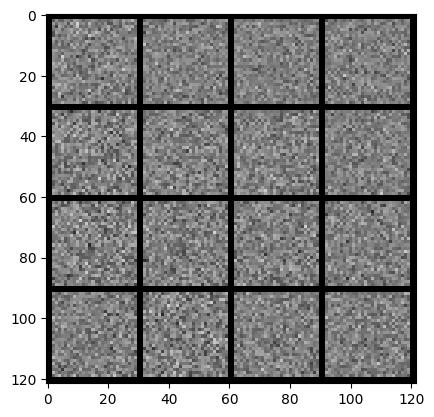

  0%|          | 0/469 [00:00<?, ?it/s]

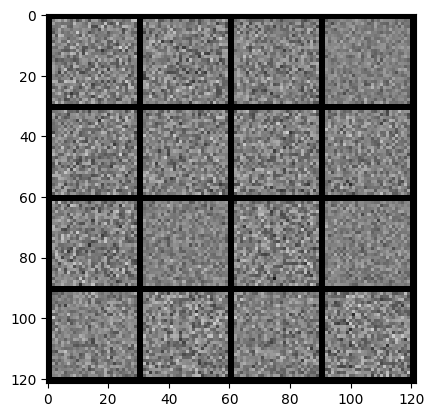

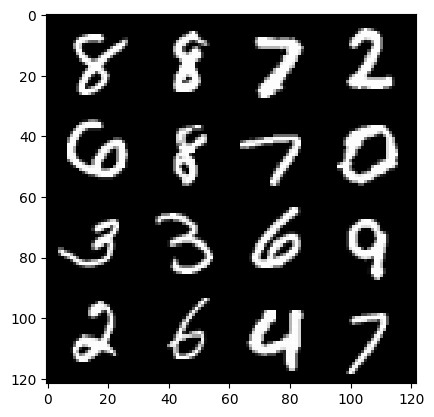

Epoch 0, step 0: Generator loss: 0.0022478087743123373, Discriminator loss: 0.004622135957082113


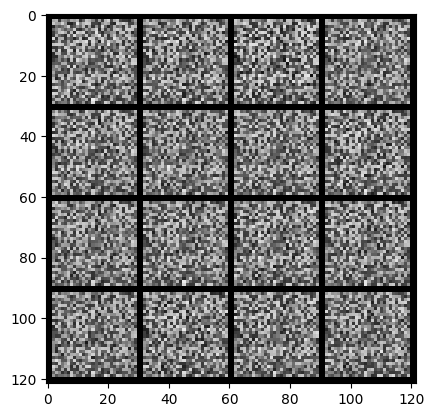

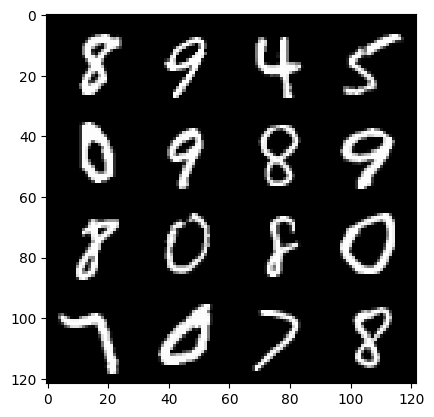

Epoch 0, step 300: Generator loss: 0.6536632217963534, Discriminator loss: 1.3863056365648911


  0%|          | 0/469 [00:00<?, ?it/s]

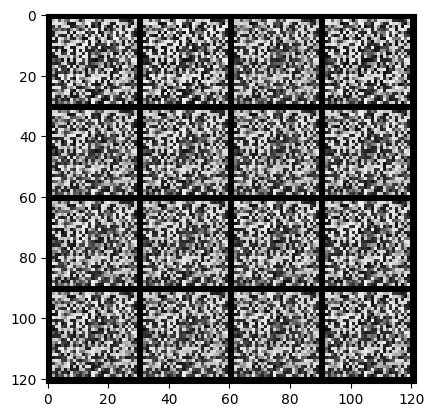

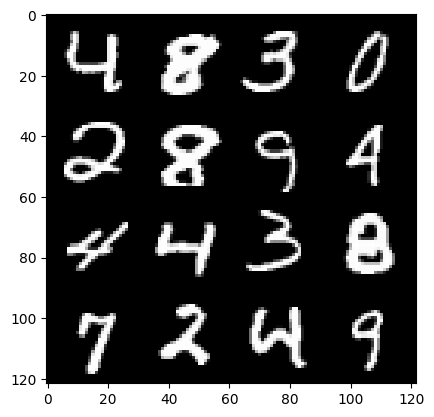

Epoch 1, step 600: Generator loss: 0.6104005877176928, Discriminator loss: 1.386296519438427


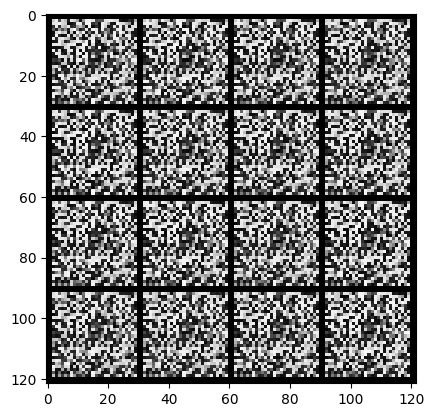

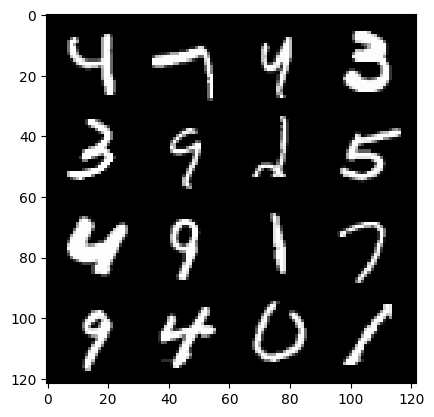

Epoch 1, step 900: Generator loss: 0.5959343373775482, Discriminator loss: 1.3862957445780453


  0%|          | 0/469 [00:00<?, ?it/s]

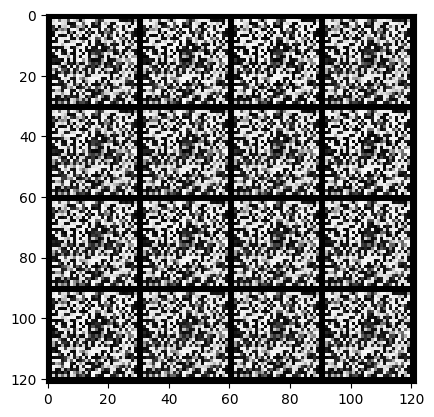

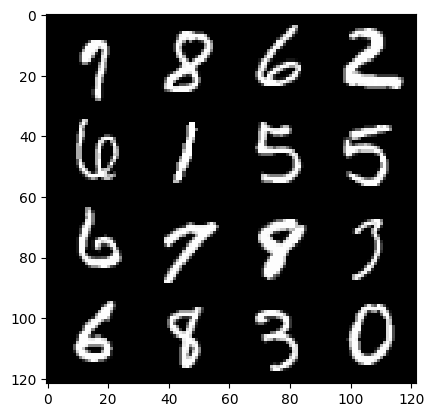

Epoch 2, step 1200: Generator loss: 0.5915240607659021, Discriminator loss: 1.3862953678766894


  0%|          | 0/469 [00:00<?, ?it/s]

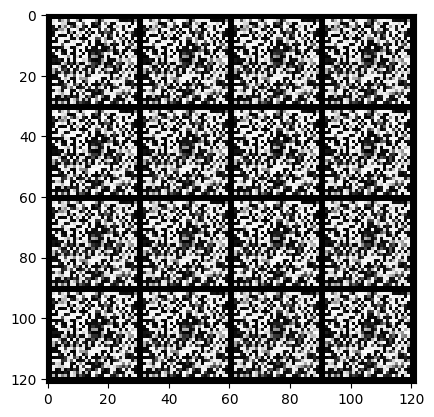

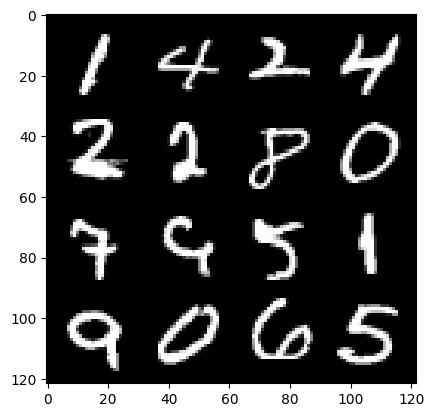

Epoch 3, step 1500: Generator loss: 0.5906830334663392, Discriminator loss: 1.386295169194536


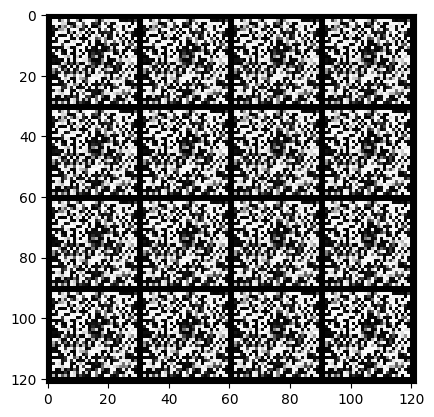

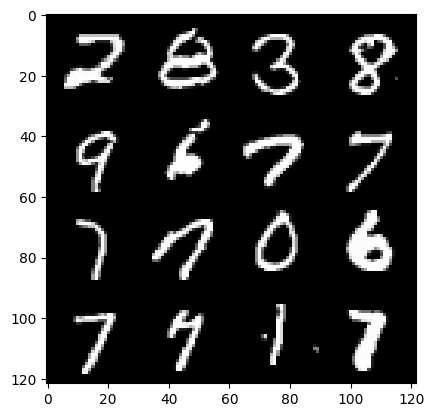

Epoch 3, step 1800: Generator loss: 0.5914652617772422, Discriminator loss: 1.3862950074672673


  0%|          | 0/469 [00:00<?, ?it/s]

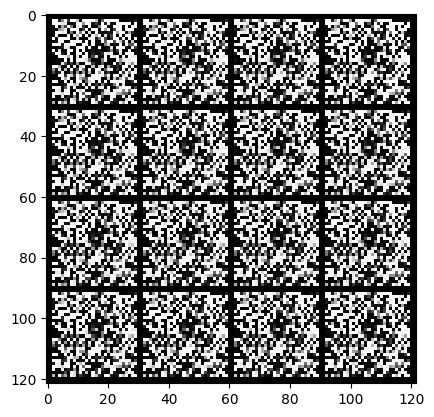

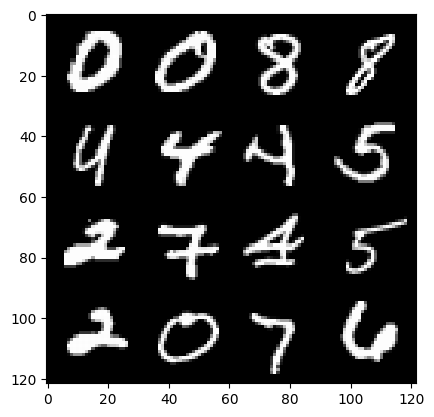

Epoch 4, step 2100: Generator loss: 0.5928485786914831, Discriminator loss: 1.3862948946158085


  0%|          | 0/469 [00:00<?, ?it/s]

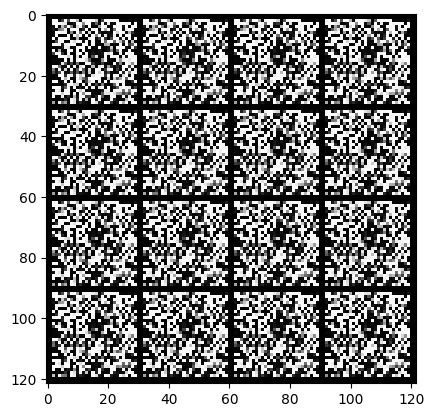

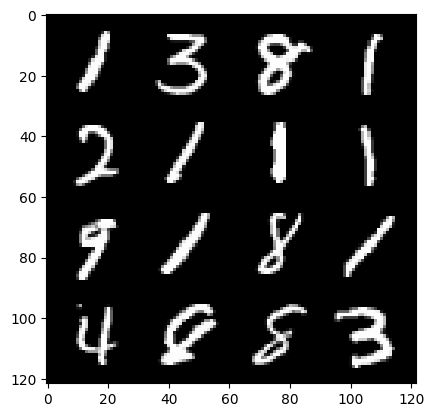

Epoch 5, step 2400: Generator loss: 0.5944035585721337, Discriminator loss: 1.3862948207060475


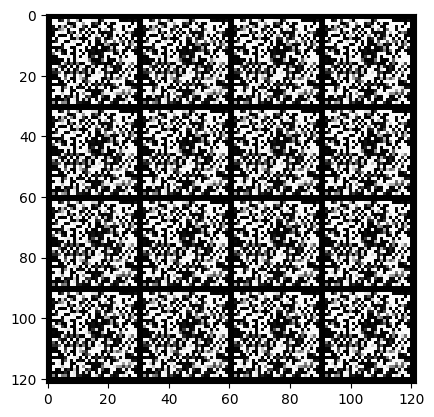

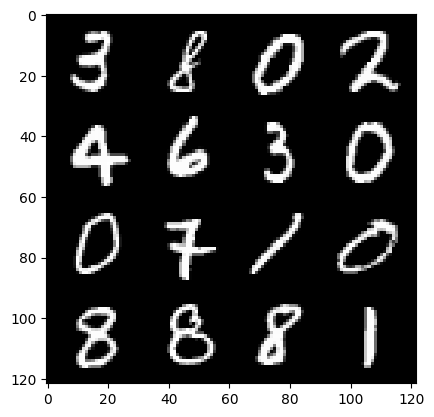

Epoch 5, step 2700: Generator loss: 0.5965507954359053, Discriminator loss: 1.3862947591145836


  0%|          | 0/469 [00:00<?, ?it/s]

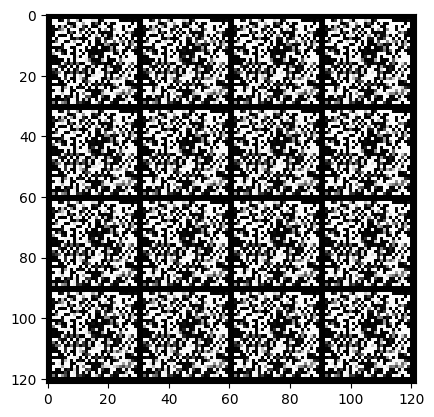

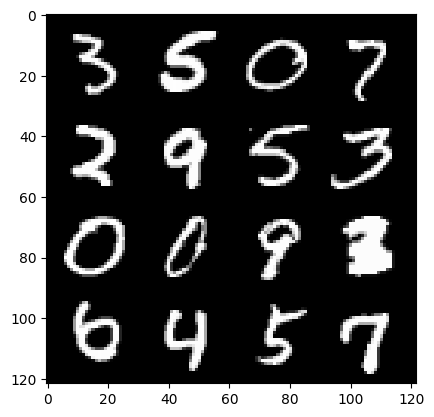

Epoch 6, step 3000: Generator loss: 0.5985253234704333, Discriminator loss: 1.3862946903705609


  0%|          | 0/469 [00:00<?, ?it/s]

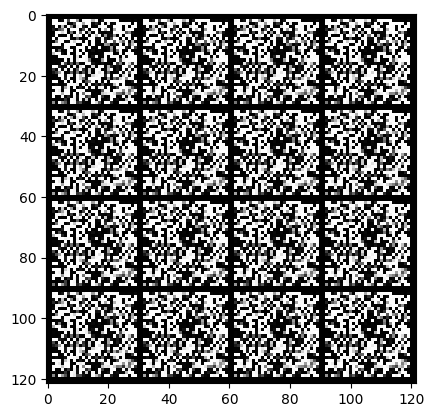

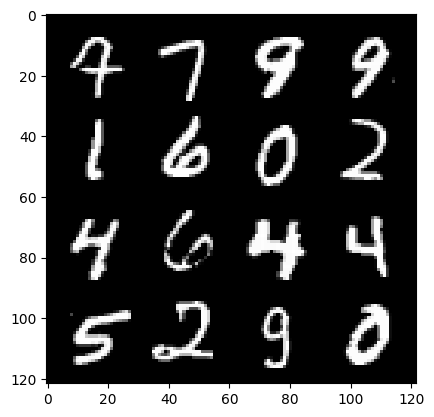

Epoch 7, step 3300: Generator loss: 0.6005250344673789, Discriminator loss: 1.3862946438789372


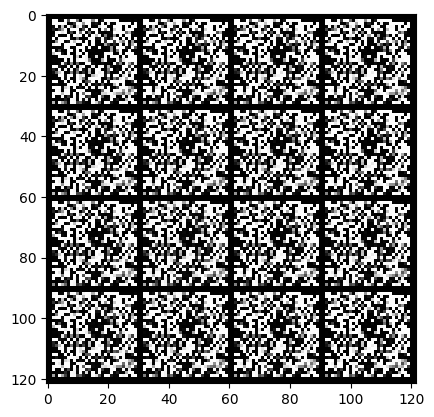

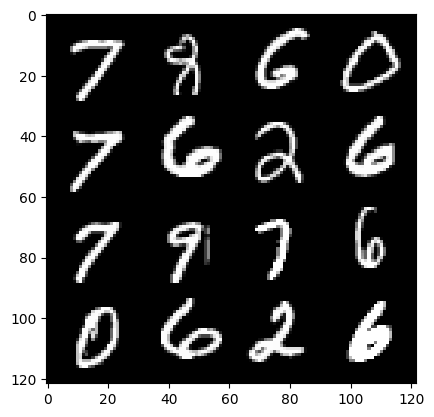

Epoch 7, step 3600: Generator loss: 0.6025130802392955, Discriminator loss: 1.3862946108977026


  0%|          | 0/469 [00:00<?, ?it/s]

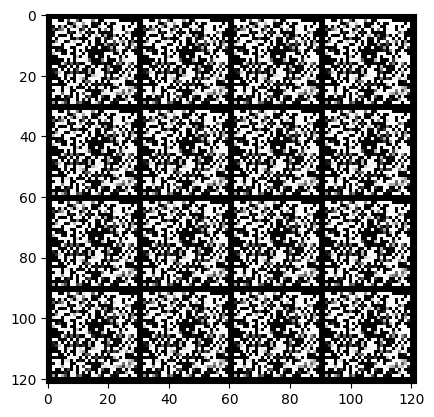

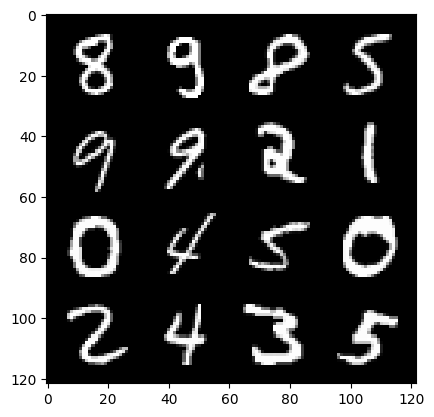

Epoch 8, step 3900: Generator loss: 0.6047031372785571, Discriminator loss: 1.3862946025530534


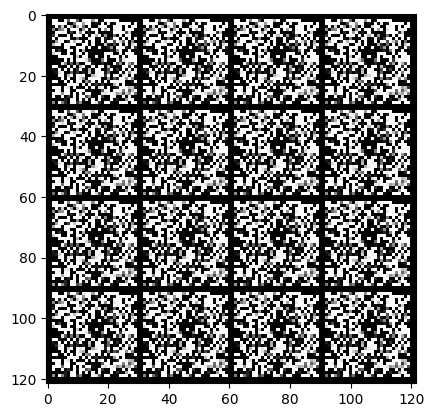

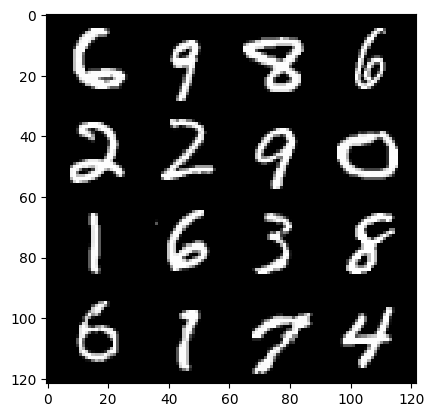

Epoch 8, step 4200: Generator loss: 0.6066361308097841, Discriminator loss: 1.386294584274295


  0%|          | 0/469 [00:00<?, ?it/s]

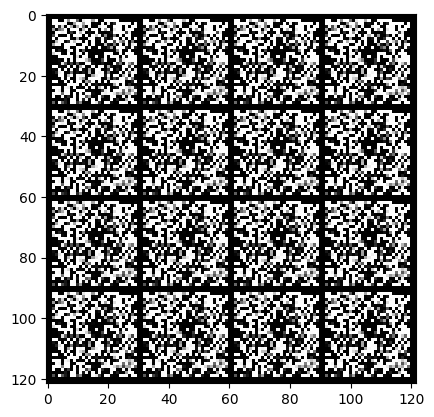

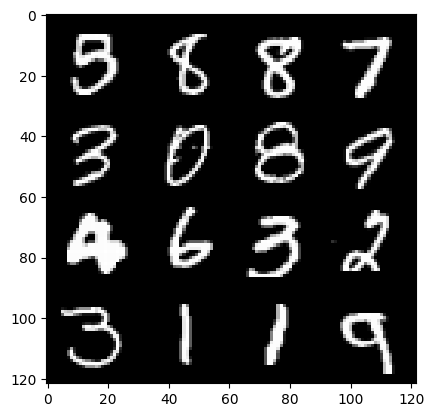

Epoch 9, step 4500: Generator loss: 0.6083729412158331, Discriminator loss: 1.386294569174452


  0%|          | 0/469 [00:00<?, ?it/s]

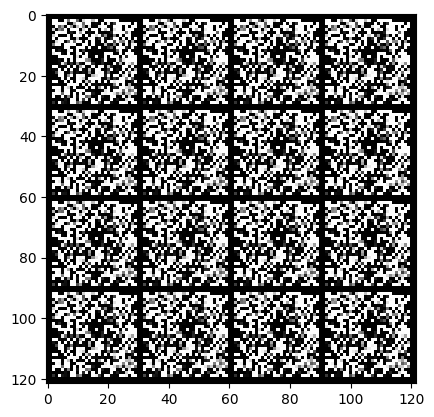

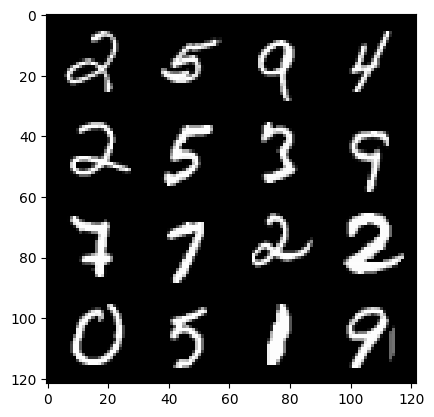

Epoch 10, step 4800: Generator loss: 0.6099628070990241, Discriminator loss: 1.3862945501009656


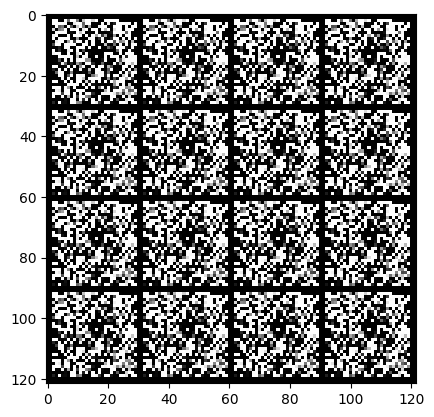

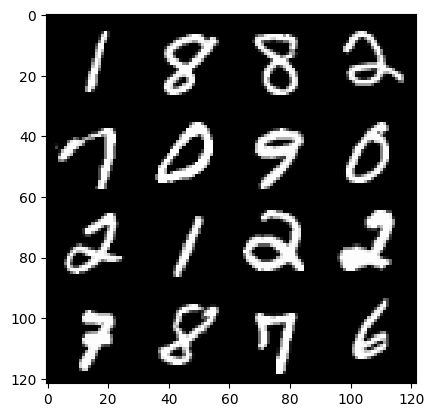

Epoch 10, step 5100: Generator loss: 0.6112846976518633, Discriminator loss: 1.3862945346037587


  0%|          | 0/469 [00:00<?, ?it/s]

In [ ]:
gen = Generator(d_z).to(device)
generator_optimizer = torch.optim.Adam(gen.parameters(), lr=learning_rate)

disc = Discriminator().to(device)
discriminator_optimizer = torch.optim.Adam(disc.parameters(), lr=learning_rate)

print(gen)
print(disc)

x, y = next(iter(dataloader))
print(x.shape, y.shape)
print(y[:10])

noise = generator_noise(batch_size, d_z)
fake = gen(noise)
show(fake)

training_loop(gen, disc, generator_optimizer, discriminator_optimizer, loss_func, dataloader, epochs, d_z)